# 0 Set paths, devices, etc.

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 

In [2]:
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

import h5py
import csv
import os

from datasets import Dataset, DatasetDict

import matplotlib.pyplot as plt

In [3]:
# notebook_login()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
data_dir = 'drive/MyDrive/neuro2voc/task_4/data/' # some data in the first section (before more) are from task_3
saving_data_dir = 'drive/MyDrive/neuro2voc/task_4/data/'
load_tensor_data_dir = data_dir+'1_tensors/data_'

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cpu



# 1 Load data and inspect

In [ ]:
before = "750"
after = "750"

### 1.1 Load the data

In [ ]:
tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

In [ ]:
tensor_1.shape

torch.Size([417, 75, 1500])

### 1.3 Function

In [10]:
def sliding_window_sum(tensor, window_size, step_size, centered=False):
    num_samples, num_input_dimensions, sequence_length = tensor.shape
    summarized_data = []

    if centered:
        half_window = window_size // 2
        start_idx = half_window
        end_idx = sequence_length - half_window
    else:
        start_idx = 0
        end_idx = sequence_length - window_size + 1

    for i in range(start_idx, end_idx, step_size):
        if centered:
            start = max(i - half_window, 0)
            end = min(i + half_window, sequence_length)
        else:
            start = i
            end = i + window_size

        # Sum the data in the window along the sequence length dimension
        window_sum = tensor[:, :, start:end].sum(axis=2)
        summarized_data.append(window_sum)

    summarized_data = np.stack(summarized_data, axis=2)
    return summarized_data

# 2 Plot and stuff

In [ ]:
window_size = 500
step_size = 1

non_centered_data = sliding_window_sum(tensor_1, window_size, step_size, centered=False)
centered_data = sliding_window_sum(tensor_1, window_size, step_size, centered=True)

In [ ]:
non_centered_data.shape

(417, 75, 1001)

In [ ]:
centered_data.shape

(417, 75, 1000)

In [ ]:
def plot_single_channel(data, channel_index, title):
    plt.figure(figsize=(10, 6))
    plt.plot(data[5, channel_index, :])
    plt.title(title)
    plt.xlabel('Window Index')
    plt.ylabel('Summed Value')
    plt.show()

In [ ]:
# channel_index = 49
# plot_single_channel(non_centered_data, channel_index, 'Non-Centered Sliding Window Sum (Channel 0)')
# plot_single_channel(centered_data, channel_index, 'Centered Sliding Window Sum (Channel 0)')

In [8]:
def plot_all_channels(data, title):
    plt.figure(figsize=(20, 10))
    for channel_index in range(data.shape[1]):
        plt.plot(data[0, channel_index, :], label=f'Channel {channel_index}')
    plt.title(title)
    plt.xlabel('Window Index')
    plt.ylabel('Summed Value')
    plt.show()

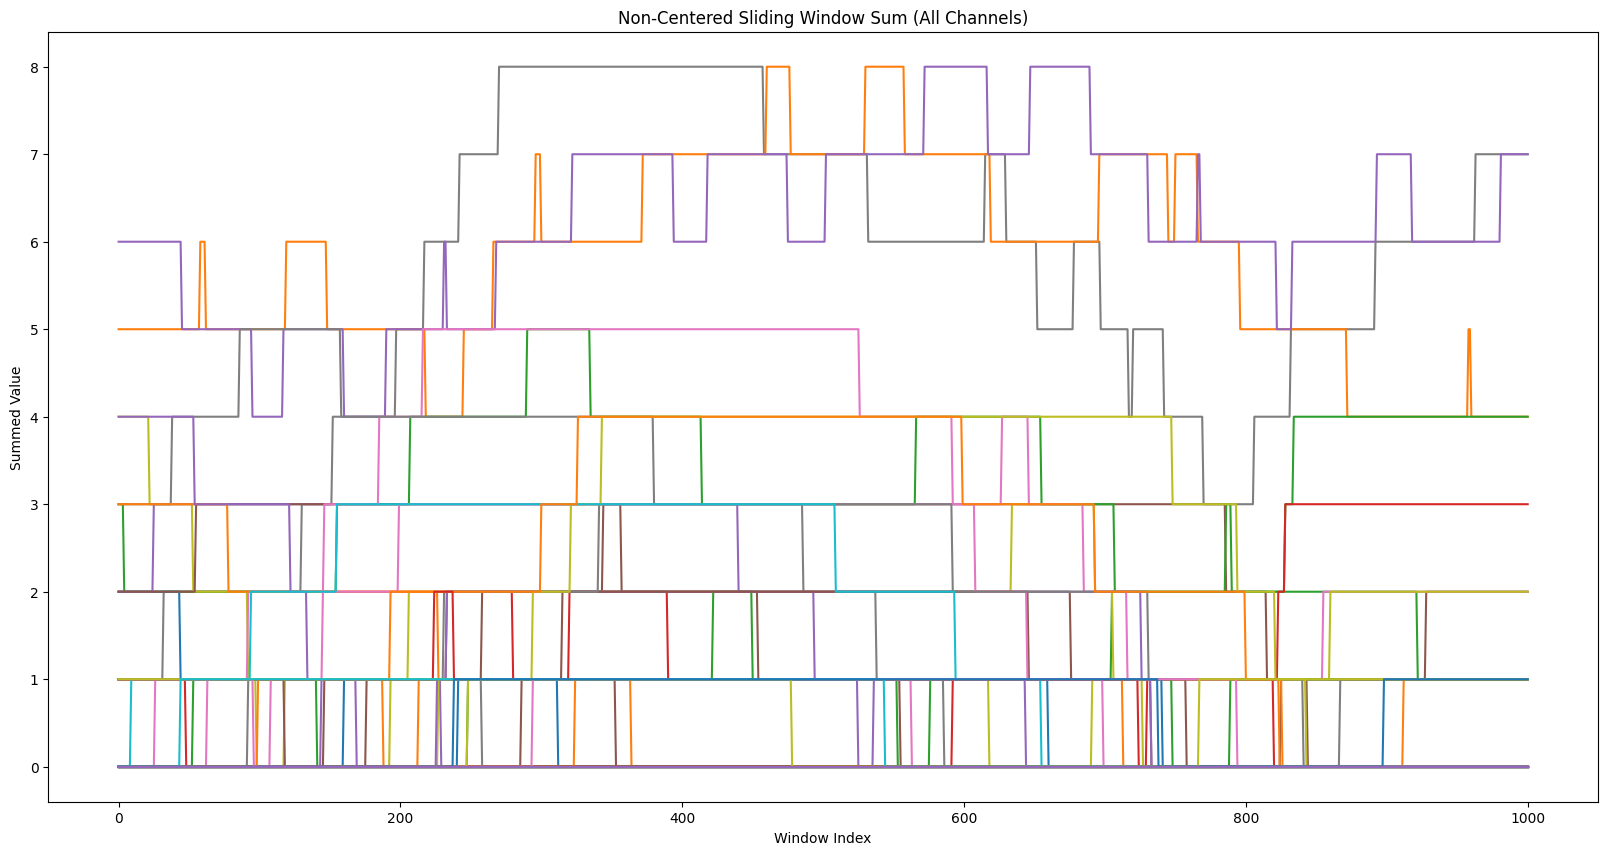

In [ ]:
plot_all_channels(non_centered_data, 'Non-Centered Sliding Window Sum (All Channels)')

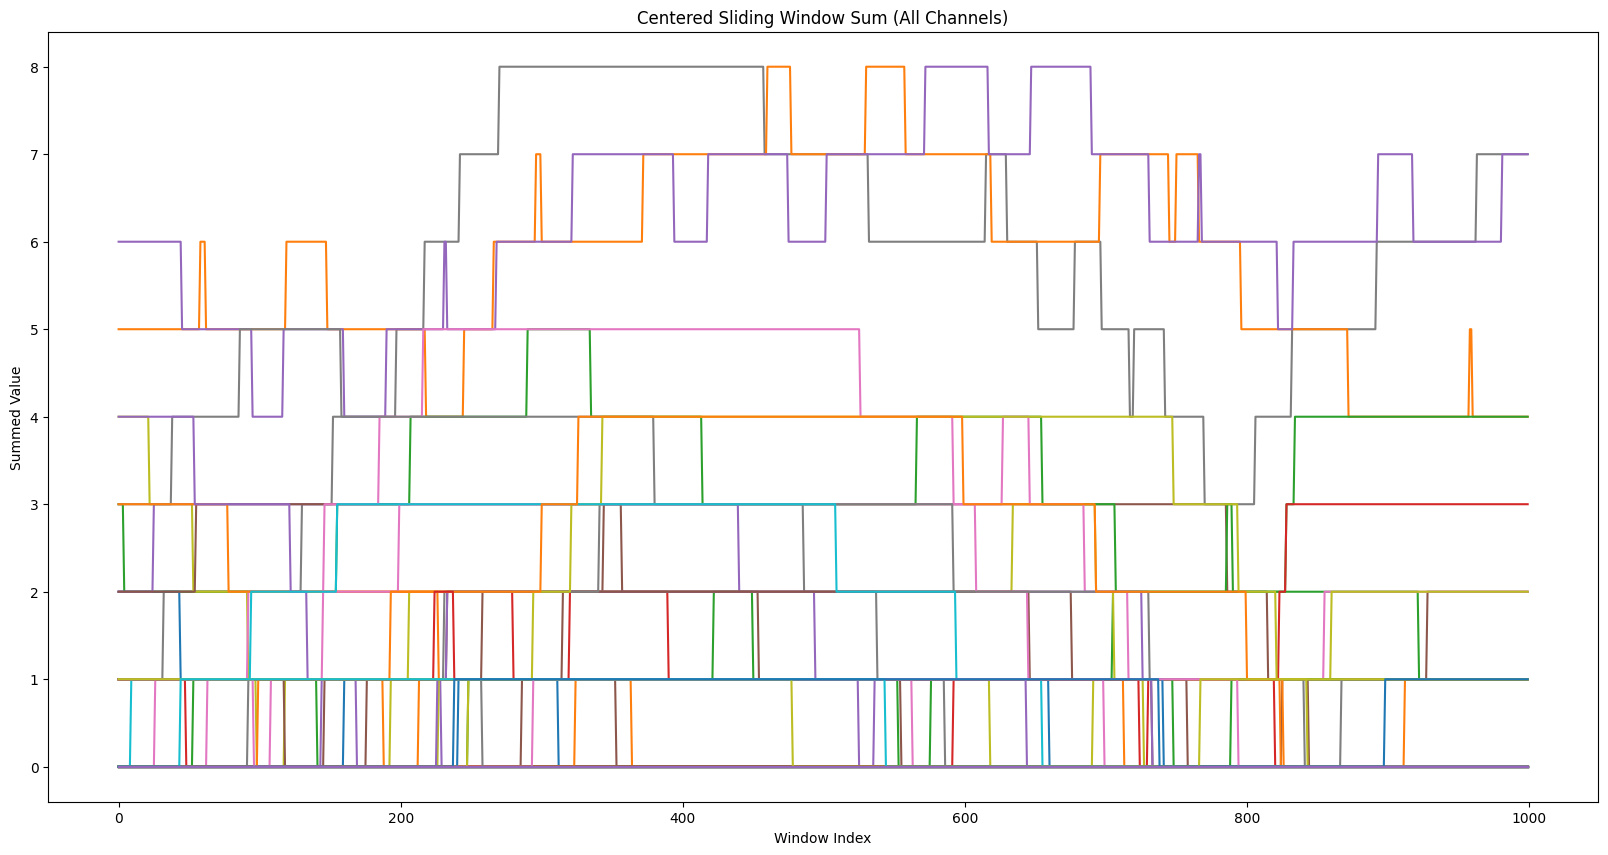

In [ ]:
plot_all_channels(centered_data, 'Centered Sliding Window Sum (All Channels)')

In [9]:
def sliding_window_sum_torch(tensor, window_size, step_size, centered=False):
    num_samples, num_input_dimensions, sequence_length = tensor.shape
    summarized_data = []

    if centered:
        half_window = window_size // 2
        start_idx = half_window
        end_idx = sequence_length - half_window
    else:
        start_idx = 0
        end_idx = sequence_length - window_size + 1

    for i in range(start_idx, end_idx, step_size):
        if centered:
            start = max(i - half_window, 0)
            end = min(i + half_window, sequence_length)
        else:
            start = i
            end = i + window_size

        # Sum the data in the window along the sequence length dimension
        window_sum = tensor[:, :, start:end].sum(dim=2)
        summarized_data.append(window_sum)

    summarized_data = torch.stack(summarized_data, dim=2)
    return summarized_data

In [ ]:
non_centered_data_torch = sliding_window_sum_torch(tensor_1, window_size, step_size, centered=False)
centered_data_torch = sliding_window_sum_torch(tensor_1, window_size, step_size, centered=True)

In [ ]:
def plot_all_channels_torch(data, title):
    data = data.cpu().numpy()  # Convert to numpy for plotting
    plt.figure(figsize=(20, 10))
    for channel_index in range(data.shape[1]):
        plt.plot(data[0, channel_index, :], label=f'Channel {channel_index}')
    plt.title(title)
    plt.xlabel('Window Index')
    plt.ylabel('Summed Value')
    plt.show()

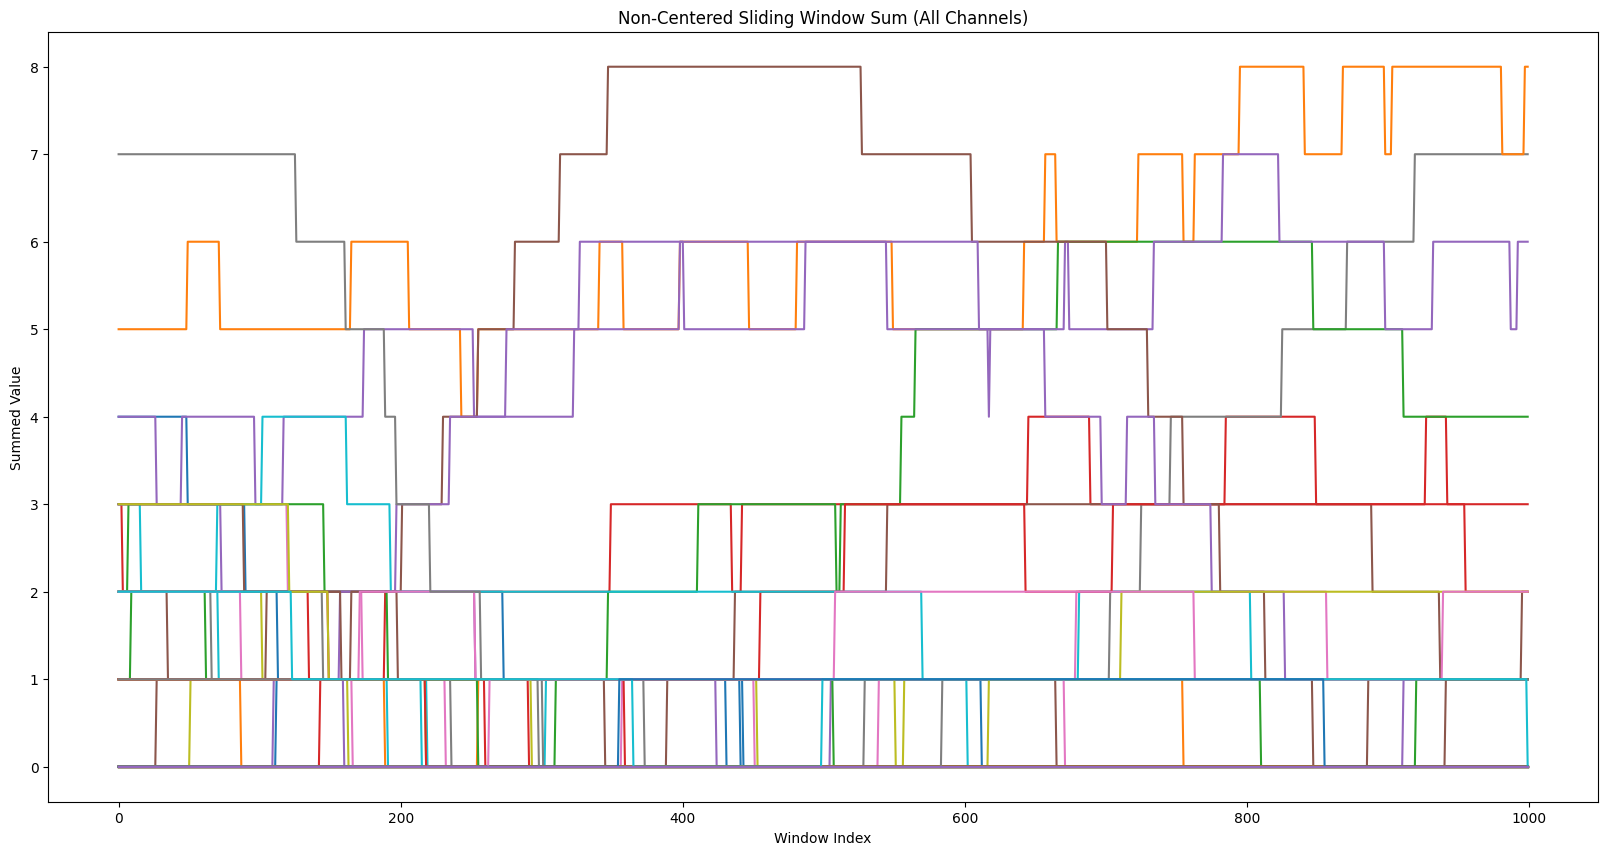

In [ ]:
plot_all_channels_torch(centered_data_3, 'Non-Centered Sliding Window Sum (All Channels)')

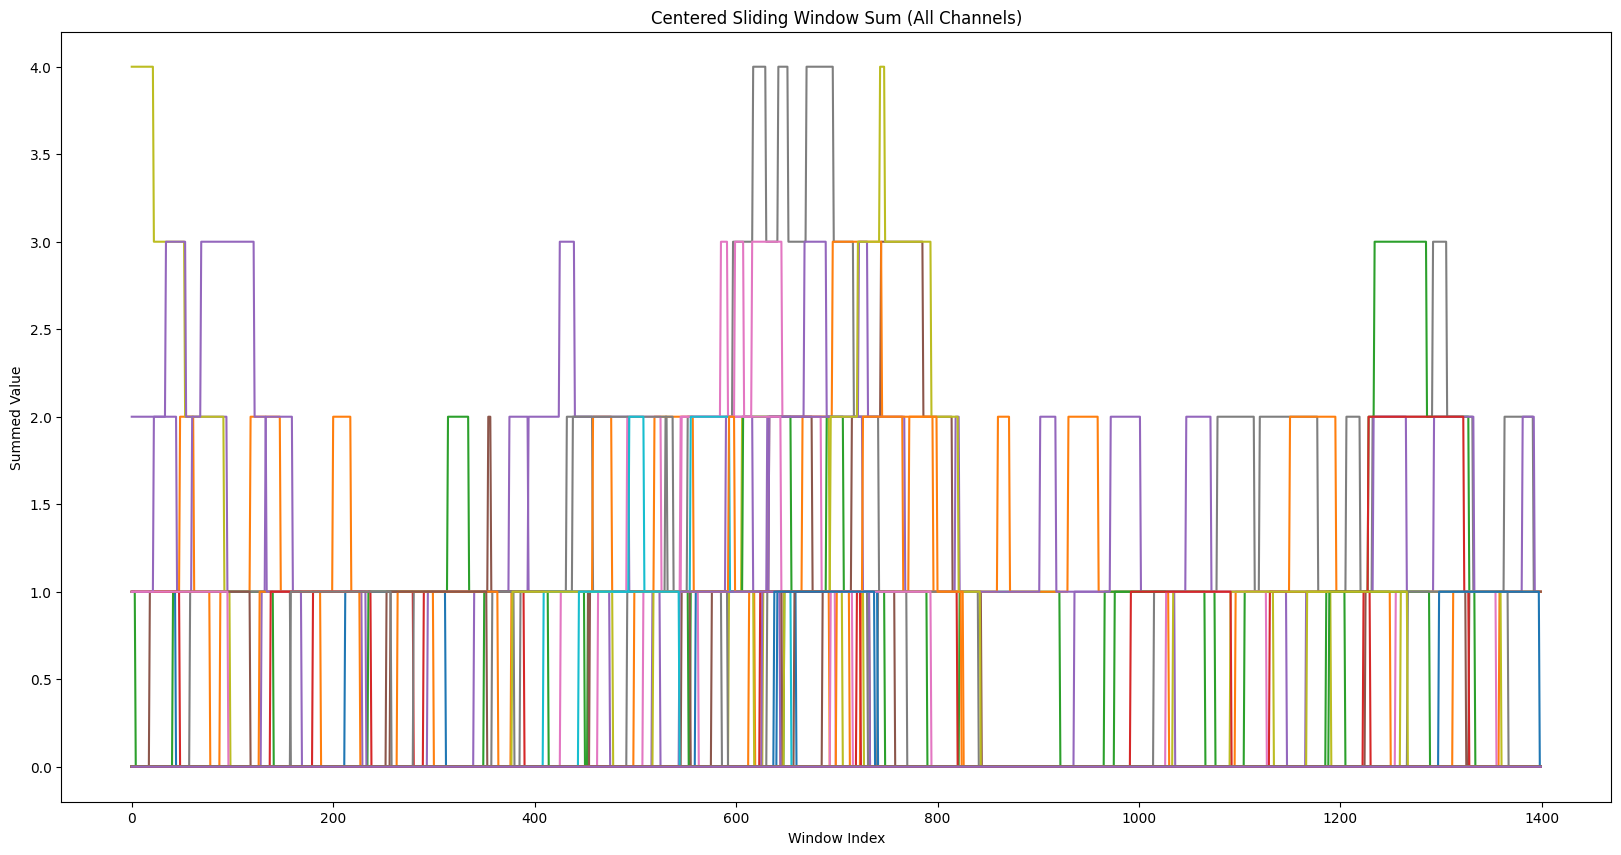

In [ ]:
plot_all_channels_torch(centered_data_torch, 'Centered Sliding Window Sum (All Channels)')

# 2 Create for all three tensors

In [ ]:
before = "0"
after = "1000"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{saving_data_dir}1_tensors/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{saving_data_dir}1_tensors/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{saving_data_dir}1_tensors/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {saving_data_dir}1_tensors/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/1_tensors/data_1-3_0_1000_500_1.pt


In [ ]:
before = "0"
after = "1000"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 400
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{saving_data_dir}1_tensors/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{saving_data_dir}1_tensors/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{saving_data_dir}1_tensors/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {saving_data_dir}1_tensors/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/1_tensors/data_1-3_0_1000_400_1.pt


In [ ]:
before = "0"
after = "1000"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 600
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{saving_data_dir}1_tensors/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{saving_data_dir}1_tensors/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{saving_data_dir}1_tensors/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {saving_data_dir}1_tensors/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/1_tensors/data_1-3_0_1000_600_1.pt


In [ ]:
before = "750"
after = "1000"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{saving_data_dir}1_tensors/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{saving_data_dir}1_tensors/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{saving_data_dir}1_tensors/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {saving_data_dir}1_tensors/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/1_tensors/data_1-3_750_1000_500_1.pt


In [ ]:
before = "750"
after = "1000"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 600
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{saving_data_dir}1_tensors/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{saving_data_dir}1_tensors/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{saving_data_dir}1_tensors/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {saving_data_dir}1_tensors/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/1_tensors/data_1-3_750_1000_600_1.pt


In [ ]:
before = "400"
after = "1000"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{saving_data_dir}1_tensors/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{saving_data_dir}1_tensors/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{saving_data_dir}1_tensors/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {saving_data_dir}1_tensors/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/1_tensors/data_1-3_400_1000_500_1.pt


In [ ]:
before = "400"
after = "1000"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 700
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{saving_data_dir}1_tensors/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{saving_data_dir}1_tensors/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{saving_data_dir}1_tensors/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {saving_data_dir}1_tensors/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/1_tensors/data_1-3_400_1000_700_1.pt


# 3 Previously loading from task 3, now loading from task 4

In [ ]:
data_dir = 'drive/MyDrive/neuro2voc/task_4/data/'
load_tensor_data_dir = data_dir+'1_tensors/data_'

In [ ]:
before = "2000"
after = "1000"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{data_dir}2_concatenated/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{data_dir}2_concatenated/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{data_dir}2_concatenated/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {data_dir}2_concatenated/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/2_concatenated/data_1-3_2000_1000_500_1.pt


In [ ]:
before = "2000"
after = "1000"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 1000
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{data_dir}2_concatenated/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{data_dir}2_concatenated/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{data_dir}2_concatenated/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {data_dir}2_concatenated/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/2_concatenated/data_1-3_2000_1000_1000_1.pt


In [ ]:
before = "2000"
after = "750"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{data_dir}2_concatenated/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{data_dir}2_concatenated/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{data_dir}2_concatenated/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {data_dir}2_concatenated/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/2_concatenated/data_1-3_2000_750_500_1.pt


In [ ]:
before = "2000"
after = "750"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 1000
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{data_dir}2_concatenated/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{data_dir}2_concatenated/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{data_dir}2_concatenated/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {data_dir}2_concatenated/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/2_concatenated/data_1-3_2000_750_1000_1.pt


In [ ]:
before = "2000"
after = "1250"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 1000
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{data_dir}2_concatenated/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{data_dir}2_concatenated/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{data_dir}2_concatenated/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {data_dir}2_concatenated/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/2_concatenated/data_1-3_2000_1250_1000_1.pt


In [ ]:
before = "2000"
after = "1250"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{data_dir}2_concatenated/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{data_dir}2_concatenated/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{data_dir}2_concatenated/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {data_dir}2_concatenated/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

In [ ]:
before = "1500"
after = "1000"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 1000
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{data_dir}2_concatenated/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{data_dir}2_concatenated/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{data_dir}2_concatenated/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {data_dir}2_concatenated/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/2_concatenated/data_1-3_1500_1000_1000_1.pt


In [ ]:
before = "1500"
after = "1000"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{data_dir}2_concatenated/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{data_dir}2_concatenated/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{data_dir}2_concatenated/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {data_dir}2_concatenated/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

In [ ]:
before = "1500"
after = "750"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{data_dir}2_concatenated/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{data_dir}2_concatenated/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{data_dir}2_concatenated/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {data_dir}2_concatenated/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

In [ ]:
before = "1500"
after = "750"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 1000
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{data_dir}2_concatenated/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{data_dir}2_concatenated/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{data_dir}2_concatenated/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {data_dir}2_concatenated/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/2_concatenated/data_1-3_1500_750_1000_1.pt


In [ ]:
before = "1250"
after = "1250"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 1000
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{data_dir}2_concatenated/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{data_dir}2_concatenated/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{data_dir}2_concatenated/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {data_dir}2_concatenated/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/2_concatenated/data_1-3_1250_1250_1000_1.pt


In [ ]:
before = "1250"
after = "1250"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{data_dir}2_concatenated/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{data_dir}2_concatenated/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{data_dir}2_concatenated/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {data_dir}2_concatenated/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/2_concatenated/data_1-3_1250_1250_500_1.pt


In [ ]:
before = "1250"
after = "750"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 1000
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{data_dir}2_concatenated/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{data_dir}2_concatenated/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{data_dir}2_concatenated/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {data_dir}2_concatenated/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/2_concatenated/data_1-3_1250_750_1000_1.pt


In [ ]:
before = "1250"
after = "750"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{data_dir}2_concatenated/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{data_dir}2_concatenated/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{data_dir}2_concatenated/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {data_dir}2_concatenated/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/2_concatenated/data_1-3_1250_750_500_1.pt


In [ ]:
before = "1000"
after = "750"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{data_dir}2_concatenated/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{data_dir}2_concatenated/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{data_dir}2_concatenated/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {data_dir}2_concatenated/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/2_concatenated/data_1-3_1000_750_500_1.pt


In [ ]:
before = "1000"
after = "750"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 1000
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{data_dir}2_concatenated/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{data_dir}2_concatenated/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{data_dir}2_concatenated/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {data_dir}2_concatenated/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/2_concatenated/data_1-3_1000_750_1000_1.pt


In [ ]:
before = "1000"
after = "1250"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 1000
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{data_dir}2_concatenated/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{data_dir}2_concatenated/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{data_dir}2_concatenated/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {data_dir}2_concatenated/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/2_concatenated/data_1-3_1000_1250_1000_1.pt


In [ ]:
before = "1000"
after = "1250"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{data_dir}2_concatenated/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{data_dir}2_concatenated/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{data_dir}2_concatenated/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {data_dir}2_concatenated/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/2_concatenated/data_1-3_1000_1250_500_1.pt


In [ ]:
before = "1000"
after = "1000"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{data_dir}2_concatenated/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{data_dir}2_concatenated/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{data_dir}2_concatenated/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {data_dir}2_concatenated/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/2_concatenated/data_1-3_1000_1000_500_1.pt


In [ ]:
before = "1000"
after = "1000"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 1000
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{data_dir}2_concatenated/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{data_dir}2_concatenated/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{data_dir}2_concatenated/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {data_dir}2_concatenated/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/2_concatenated/data_1-3_1000_1000_1000_1.pt


# More (after richard says - neuro2voc group meeting 3)

In [18]:
before = "0"
after = "750"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{saving_data_dir}1_tensors/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{saving_data_dir}1_tensors/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{saving_data_dir}1_tensors/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {saving_data_dir}1_tensors/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/1_tensors/data_1-3_0_750_500_1.pt


In [19]:
before = "0"
after = "1250"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{saving_data_dir}1_tensors/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{saving_data_dir}1_tensors/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{saving_data_dir}1_tensors/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {saving_data_dir}1_tensors/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/1_tensors/data_1-3_0_1250_500_1.pt


In [20]:
before = "400"
after = "750"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{saving_data_dir}1_tensors/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{saving_data_dir}1_tensors/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{saving_data_dir}1_tensors/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {saving_data_dir}1_tensors/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/1_tensors/data_1-3_400_750_500_1.pt


In [21]:
before = "400"
after = "1250"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{saving_data_dir}1_tensors/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{saving_data_dir}1_tensors/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{saving_data_dir}1_tensors/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {saving_data_dir}1_tensors/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/1_tensors/data_1-3_400_1250_500_1.pt


In [22]:
before = "750"
after = "1250"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{saving_data_dir}1_tensors/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{saving_data_dir}1_tensors/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{saving_data_dir}1_tensors/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {saving_data_dir}1_tensors/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/1_tensors/data_1-3_750_1250_500_1.pt


In [23]:
before = "1250"
after = "1000"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{saving_data_dir}1_tensors/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{saving_data_dir}1_tensors/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{saving_data_dir}1_tensors/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {saving_data_dir}1_tensors/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/1_tensors/data_1-3_1250_1000_500_1.pt


In [24]:
before = "750"
after = "1250"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{saving_data_dir}1_tensors/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{saving_data_dir}1_tensors/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{saving_data_dir}1_tensors/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {saving_data_dir}1_tensors/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/1_tensors/data_1-3_750_1250_500_1.pt


In [25]:
before = "1750"
after = "750"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{saving_data_dir}1_tensors/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{saving_data_dir}1_tensors/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{saving_data_dir}1_tensors/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {saving_data_dir}1_tensors/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/1_tensors/data_1-3_1750_750_500_1.pt


In [26]:
before = "1750"
after = "1000"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{saving_data_dir}1_tensors/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{saving_data_dir}1_tensors/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{saving_data_dir}1_tensors/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {saving_data_dir}1_tensors/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/1_tensors/data_1-3_1750_1000_500_1.pt


In [27]:
before = "1750"
after = "1250"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{saving_data_dir}1_tensors/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{saving_data_dir}1_tensors/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{saving_data_dir}1_tensors/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {saving_data_dir}1_tensors/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/1_tensors/data_1-3_1750_1250_500_1.pt


In [28]:
before = "2250"
after = "750"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{saving_data_dir}1_tensors/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{saving_data_dir}1_tensors/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{saving_data_dir}1_tensors/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {saving_data_dir}1_tensors/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/1_tensors/data_1-3_2250_750_500_1.pt


In [29]:
before = "2250"
after = "1000"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{saving_data_dir}1_tensors/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{saving_data_dir}1_tensors/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{saving_data_dir}1_tensors/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {saving_data_dir}1_tensors/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/1_tensors/data_1-3_2250_1000_500_1.pt


In [30]:
before = "2250"
after = "1250"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{saving_data_dir}1_tensors/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{saving_data_dir}1_tensors/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{saving_data_dir}1_tensors/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {saving_data_dir}1_tensors/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/1_tensors/data_1-3_2250_1250_500_1.pt


In [31]:
before = "2500"
after = "750"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{saving_data_dir}1_tensors/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{saving_data_dir}1_tensors/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{saving_data_dir}1_tensors/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {saving_data_dir}1_tensors/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/1_tensors/data_1-3_2500_750_500_1.pt


In [32]:
before = "2500"
after = "1000"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{saving_data_dir}1_tensors/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{saving_data_dir}1_tensors/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{saving_data_dir}1_tensors/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {saving_data_dir}1_tensors/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/1_tensors/data_1-3_2500_1000_500_1.pt


In [33]:
before = "2500"
after = "1250"

tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}.pt")

window_size = 500
step_size = 1

centered_data_1 = sliding_window_sum(tensor_1, window_size, step_size, centered=True)
centered_data_2 = sliding_window_sum(tensor_2, window_size, step_size, centered=True)
centered_data_3 = sliding_window_sum(tensor_3, window_size, step_size, centered=True)

centered_data_1 = torch.tensor(centered_data_1)
centered_data_2 = torch.tensor(centered_data_2)
centered_data_3 = torch.tensor(centered_data_3)

torch.save(centered_data_1, f'{saving_data_dir}1_tensors/data_1_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_2, f'{saving_data_dir}1_tensors/data_2_{before}_{after}_{window_size}_{step_size}.pt')
torch.save(centered_data_3, f'{saving_data_dir}1_tensors/data_3_{before}_{after}_{window_size}_{step_size}.pt')

print(f'Centered tensor saved to {saving_data_dir}1_tensors/data_1-3_{before}_{after}_{window_size}_{step_size}.pt')

Centered tensor saved to drive/MyDrive/neuro2voc/task_4/data/1_tensors/data_1-3_2500_1250_500_1.pt
